In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import h5py
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("weinanwangrutgers/pulsedb-balanced-training-and-testing")

print("Path to dataset files:", path)


100%|██████████| 17.3G/17.3G [03:33<00:00, 87.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4


In [ ]:
import os

for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_AAMI_Cal_Subset.mat
/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_CalBased_Test_Subset.mat
/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/LICENSE.txt
/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_Train_Subset.mat
/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_AAMI_Test_Subset.mat
/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_CalFree_Test_Subset.mat


In [ ]:
import h5py

file_path = "/root/.cache/kagglehub/datasets/weinanwangrutgers/pulsedb-balanced-training-and-testing/versions/4/VitalDB_Train_Subset.mat"
f = h5py.File(file_path, 'r')

# Print the root keys
print("Root keys:", list(f.keys()))

Root keys: ['#refs#', 'Subset']


In [ ]:
subset = f['Subset']
for key in subset:
    print(key)

Age
BMI
DBP
Gender
Height
SBP
Signals
Subject
Weight


In [ ]:
# Define dataset references again
ppg_dset = subset['Signals']
sbp_dset = subset['SBP']

In [ ]:
ppg = np.array(subset['Signals'][:, 1, 0:3000]).T   # (3000, 1250)
sbp = np.array(subset['SBP'][0, 0:3000])

In [ ]:

print(" PPG shape:", ppg.shape)
print(" SBP shape:", sbp.shape)

 PPG shape: (3000, 1250)
 SBP shape: (3000,)


In [ ]:
print(type(sbp))

<class 'numpy.ndarray'>


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(ppg, sbp):
    """
    Preprocess PPG and SBP data for LSTM model training.

    Parameters:
    -----------
    ppg : np.ndarray
        Shape (N, 1250). Raw PPG signals.
    sbp : np.ndarray
        Shape (N,). Raw SBP values.

    Returns:
    --------
    ppg_normalized : np.ndarray
        Shape (N, 1250, 1). Normalized PPG signals.
    sbp_scaled : np.ndarray
        Shape (N,). Scaled SBP values.
    ppg_scaler : MinMaxScaler
        Fitted scaler for PPG (for inverse transform later).
    sbp_scaler : MinMaxScaler
        Fitted scaler for SBP (for inverse transform later).
    """

    # -------------------------
    # For PPG: shape (N, 1250)
    # -------------------------
    ppg_scaler = MinMaxScaler()
    ppg_normalized = ppg_scaler.fit_transform(ppg)   # Shape: (N, 1250)
    ppg_normalized = ppg_normalized[..., np.newaxis] # Shape: (N, 1250, 1)

    # -------------------------
    # For SBP: shape (N,)
    # -------------------------
    sbp_scaler = MinMaxScaler()
    sbp_scaled = sbp_scaler.fit_transform(sbp.reshape(-1, 1)) # Shape: (N, 1)
    sbp_scaled = sbp_scaled.flatten()  # Back to (N,)

    # -------------------------
    # Debug prints
    # -------------------------
    print(f"PPG range after scaling: [{ppg_normalized.min():.4f}, {ppg_normalized.max():.4f}]")
    print(f"SBP range after scaling: [{sbp_scaled.min():.4f}, {sbp_scaled.max():.4f}]")
    print(f"PPG shape: {ppg_normalized.shape}")
    print(f"SBP shape: {sbp_scaled.shape}")

    return ppg_normalized, sbp_scaled, ppg_scaler, sbp_scaler


PPG range after scaling: [0.0000, 1.0000]
SBP range after scaling: [0.0000, 1.0000]
PPG shape: (3000, 1250, 1)
SBP shape: (3000,)


In [ ]:
# Check if PPG is actually normalized
print("PPG min/max:", ppg_normalized.min(), ppg_normalized.max())
# Should be close to 0 and 1

# Check SBP distribution
print("SBP unique values:", len(np.unique(sbp_scaled)))
print("SBP std:", sbp_scaled.std())

PPG min/max: 0.0 1.0000000000000002
SBP unique values: 3000
SBP std: 0.14271855739550215


In [ ]:
from torch.utils.data import Dataset

class PPGDataset(Dataset):
    def __init__(self, ppg_normalized, sbp_scaled):
        self.X = torch.tensor(ppg_normalized, dtype=torch.float32)  # (N, 1250, 1)
        self.y = torch.tensor(sbp_scaled, dtype=torch.float32)      # (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]





In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

ppg_train, ppg_val, sbp_train, sbp_val = train_test_split(ppg_normalized, sbp_scaled, test_size=0.2, random_state=42)

train_loader = DataLoader(PPGDataset(ppg_train, sbp_train), batch_size=32, shuffle=True)
val_loader = DataLoader(PPGDataset(ppg_val, sbp_val), batch_size=32)


In [ ]:
print(f"Train PPG shape: {ppg_train.shape}")
print(f"Train SBP shape: {sbp_train.shape}")
print(f"Sample batch shapes from train_loader:")

for X, y in train_loader:
    print(f"X: {X.shape}")
    print(f"y: {y.shape}")  #
    break


Train PPG shape: (2400, 1250, 1)
Train SBP shape: (2400,)
Sample batch shapes from train_loader:
X: torch.Size([32, 1250, 1])
y: torch.Size([32])


In [ ]:
class SimplerImprovedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=512, num_layers=3, output_size=1):
        super(SimplerImprovedLSTM, self).__init__()

        # larger LSTM for better capacity
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Use average of all timesteps instead of just the last one
        # This helps the model use information from the entire PPG signal

        # Deeper network with less aggressive dropout
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, output_size)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)

        # Instead of taking just the last timestep, taking the AVERAGE of all timesteps
        # This uses information from the entire PPG signal, not just the end
        averaged_output = torch.mean(lstm_out, dim=1)  # (batch, hidden_size)

        # Pass through the deeper network
        prediction = self.fc_layers(averaged_output)

        return prediction.squeeze()

In [ ]:
def train_simple_improved(model, train_loader, val_loader, num_epochs=200):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # MSE loss with the improved architecture
    criterion = nn.MSELoss()

    # Lower learning rate for more stable training
    optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

    # Simple learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    print(f"Training on: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_ppg, batch_sbp in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_ppg, batch_sbp = batch_ppg.to(device), batch_sbp.to(device)

            optimizer.zero_grad()
            predictions = model(batch_ppg)
            loss = criterion(predictions, batch_sbp)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch_ppg, batch_sbp in val_loader:
                batch_ppg, batch_sbp = batch_ppg.to(device), batch_sbp.to(device)
                predictions = model(batch_ppg)
                loss = criterion(predictions, batch_sbp)
                val_loss += loss.item()
                val_batches += 1

        # Calculate averages
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Simple early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_loss': best_val_loss,
                'epoch': epoch
            }, 'best_simple_improved_model.pth')
        else:
            patience_counter += 1

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {avg_train_loss:.6f}')
            print(f'  Val Loss: {avg_val_loss:.6f}')
            print(f'  Learning Rate: {current_lr:.7f}')
            print(f'  Best Val Loss: {best_val_loss:.6f}')
            print('-' * 50)

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    checkpoint = torch.load('best_simple_improved_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    return train_losses, val_losses


In [ ]:
def evaluate_simple_model(model, val_loader, sbp_scaler, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_ppg, batch_sbp in val_loader:
            batch_ppg, batch_sbp = batch_ppg.to(device), batch_sbp.to(device)
            predictions = model(batch_ppg)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_sbp.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(all_predictions)  # Already scaled [0,1]
    targets = np.array(all_targets)          # Already scaled [0,1]

    # Transform back to original scale
    predictions_original = sbp_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    targets_original = sbp_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = np.mean((predictions_original - targets_original) ** 2)
    mae = np.mean(np.abs(predictions_original - targets_original))
    rmse = np.sqrt(mse)
    correlation = np.corrcoef(targets_original, predictions_original)[0, 1]

    print(f"\nSimple Improved Model Results:")
    print(f"MSE: {mse:.2f} mmHg²")
    print(f"MAE: {mae:.2f} mmHg")
    print(f"RMSE: {rmse:.2f} mmHg")
    print(f"Correlation: {correlation:.3f}")

    return mse, mae, rmse, correlation, targets_original, predictions_original

Creating enhanced model...
Starting training...
Training on: cuda
Model parameters: 5,429,761


Epoch 10/200: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 10/200:
  Train Loss: 0.018398
  Val Loss: 0.018970
  Learning Rate: 0.0003000
  Best Val Loss: 0.018767
--------------------------------------------------


Epoch 20/200: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 20/200:
  Train Loss: 0.016203
  Val Loss: 0.018567
  Learning Rate: 0.0003000
  Best Val Loss: 0.018342
--------------------------------------------------


Epoch 30/200: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 30/200:
  Train Loss: 0.016085
  Val Loss: 0.019077
  Learning Rate: 0.0003000
  Best Val Loss: 0.018056
--------------------------------------------------


Epoch 40/200: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 40/200:
  Train Loss: 0.015648
  Val Loss: 0.017738
  Learning Rate: 0.0002100
  Best Val Loss: 0.017738
--------------------------------------------------


Epoch 50/200: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 50/200:
  Train Loss: 0.015230
  Val Loss: 0.017831
  Learning Rate: 0.0002100
  Best Val Loss: 0.017527
--------------------------------------------------


Epoch 60/200: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 60/200:
  Train Loss: 0.015128
  Val Loss: 0.017668
  Learning Rate: 0.0002100
  Best Val Loss: 0.017375
--------------------------------------------------


Epoch 70/200: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 70/200:
  Train Loss: 0.015279
  Val Loss: 0.017299
  Learning Rate: 0.0002100
  Best Val Loss: 0.017289
--------------------------------------------------


Epoch 80/200: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s]


Epoch 80/200:
  Train Loss: 0.014871
  Val Loss: 0.017299
  Learning Rate: 0.0001470
  Best Val Loss: 0.017204
--------------------------------------------------


Epoch 90/200: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 90/200:
  Train Loss: 0.014909
  Val Loss: 0.017345
  Learning Rate: 0.0001470
  Best Val Loss: 0.017178
--------------------------------------------------


Epoch 100/200: 100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 100/200:
  Train Loss: 0.014974
  Val Loss: 0.017281
  Learning Rate: 0.0001470
  Best Val Loss: 0.017117
--------------------------------------------------


Epoch 110/200: 100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Epoch 110/200:
  Train Loss: 0.014864
  Val Loss: 0.017251
  Learning Rate: 0.0001470
  Best Val Loss: 0.017117
--------------------------------------------------


Epoch 117/200: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Early stopping at epoch 117


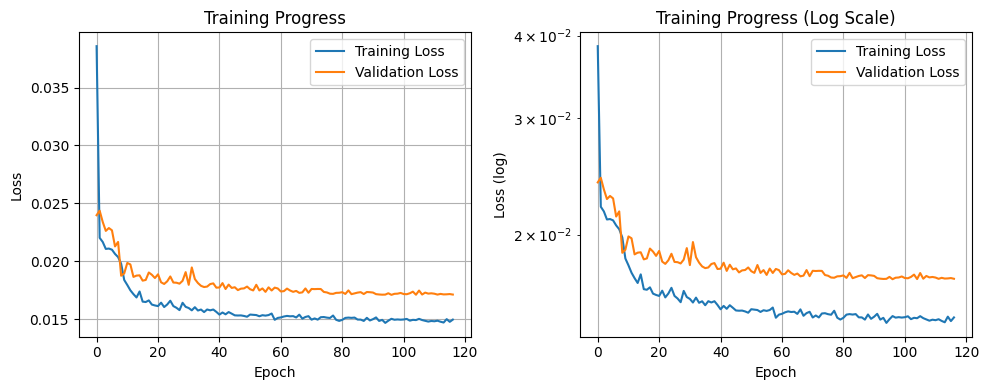


Simple Improved Model Results:
MSE: 156.36 mmHg²
MAE: 9.74 mmHg
RMSE: 12.50 mmHg
Correlation: 0.498


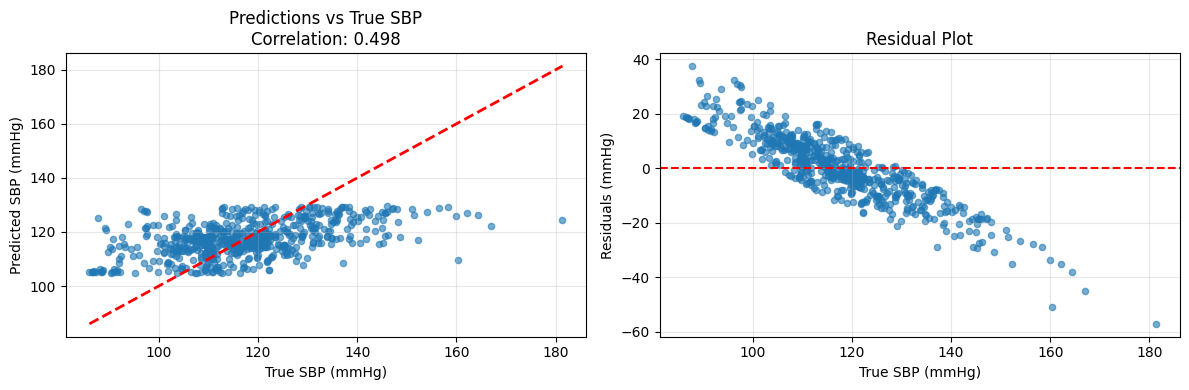


Key improvements made:
1. Much larger LSTM (512 hidden units vs 256)
2. 3 LSTM layers vs 2 for better depth
3. Less aggressive dropout to retain more info
4. MSE loss for direct regression
5. Longer training (200 epochs)
6. Even lower learning rate for stability


In [ ]:
# Create and train the simple improved model
print("Creating enhanced model...")
improved_model = SimplerImprovedLSTM(input_size=1, hidden_size=512, num_layers=3)

print("Starting training...")
train_losses, val_losses = train_simple_improved(improved_model, train_loader, val_loader)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the model and get results for plotting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse, mae, rmse, correlation, targets_original, predictions_original = evaluate_simple_model(improved_model, val_loader, sbp_scaler, device)

# Plot results
plt.figure(figsize=(12, 4))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(targets_original, predictions_original, alpha=0.6, s=20)
plt.plot([targets_original.min(), targets_original.max()],
         [targets_original.min(), targets_original.max()], 'r--', lw=2)
plt.xlabel('True SBP (mmHg)')
plt.ylabel('Predicted SBP (mmHg)')
plt.title(f'Predictions vs True SBP\nCorrelation: {correlation:.3f}')
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = predictions_original - targets_original
plt.scatter(targets_original, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True SBP (mmHg)')
plt.ylabel('Residuals (mmHg)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey improvements made:")
print("1. Much larger LSTM (512 hidden units vs 256)")
print("2. 3 LSTM layers vs 2 for better depth")
print("3. Less aggressive dropout to retain more info")
print("4. MSE loss for direct regression")
print("5. Longer training (200 epochs)")
print("6. Even lower learning rate for stability")

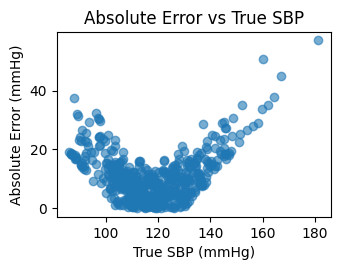

In [ ]:
plt.subplot(2, 2, 4)
plt.scatter(targets_original, np.abs(residuals), alpha=0.6)
plt.xlabel("True SBP (mmHg)")
plt.ylabel("Absolute Error (mmHg)")
plt.title("Absolute Error vs True SBP")
plt.tight_layout()
plt.show()